# Import

In [66]:
import numpy as np
from scipy.signal import fftconvolve
from collections import deque
from skimage.draw import disk
import matplotlib.pyplot as plt

from numpy.polynomial.polynomial import polyval2d
from numpy.polynomial.chebyshev import chebval2d
from scipy.stats import multivariate_normal

from sklearn import linear_model
import pandas as pd
from sklearn.feature_selection import mutual_info_regression
from patsy import dmatrix
from astropy.table import Table
from astropy.visualization import ZScaleInterval
interval = ZScaleInterval()

import lsst.afw.image as afwImage
# import data_process_utils as dpu
from matplotlib.patches import Circle
import matplotlib.patches as mpatches
from lsst.afw.table import BaseCatalog

# ipdiffim

from collections.abc import Sequence
import os
from typing import Union

import astropy.table
from astropy.wcs import WCS

import matplotlib.pyplot as plt
import numpy as np

import lsst.afw.display as afwDisplay
import lsst.afw.image
from lsst.afw.math import Warper, WarperConfig
import lsst.afw.table
from lsst.daf.butler import Butler
import lsst.geom as geom
from lsst.ip.diffim import AlardLuptonSubtractConfig, AlardLuptonSubtractTask, AlardLuptonPreconvolveSubtractTask
from lsst.ip.diffim import GetTemplateConfig, GetTemplateTask
from lsst.ip.diffim import DetectAndMeasureConfig, DetectAndMeasureTask, DetectAndMeasureScoreConfig, DetectAndMeasureScoreTask
import lsst.sphgeom

from lsst.pipe.tasks.makeWarp import MakeWarpConfig, MakeWarpTask
from lsst.ip.diffim import MakeKernelConfig, MakeKernelTask, PsfMatchConfig, PsfMatchConfigAL, PsfMatchConfigDF
from lsst.ip.diffim.subtractImages import _subtractImages
from lsst.ip.diffim.utils import evaluateMeanPsfFwhm, getPsfFwhm
from lsst.meas.algorithms import SourceDetectionTask, SubtractBackgroundTask
from lsst.meas.base import SingleFrameMeasurementTask
from lsst.pex.exceptions import InvalidParameterError

from lsst.ip.diffim import subtractImages

# DIA IMPROVEMENT

In [67]:
def warp_to_exposure(exposure, warp_to_exposure):
    # warp the exposure to the wcs of the warp_to_exposure
    warper = Warper(warpingKernelName='lanczos4')
    exposure_warped = warper.warpExposure(warp_to_exposure.getWcs(), exposure,
                                          destBBox=warp_to_exposure.getBBox())
    return exposure_warped

def keep_flag_astropy(src_table, flag_list=None):

    src_df = src_table.to_pandas()
    flags = src_df.loc[:, flag_list]
    keep_id = (flags.sum(axis=1) >0).to_numpy()
    src_df = src_df[keep_id].copy().reset_index(drop=True)
    flag_removed =  Table.from_pandas(src_df)
    return flag_removed

def remove_flag_astropy(src_table, flag_list=None):

    src_df = src_table.to_pandas()
    flags = src_df.loc[:, flag_list]
    keep_id = (flags.sum(axis=1) == 0).to_numpy()
    src_df = src_df[keep_id].copy().reset_index(drop=True)
    flag_removed =  Table.from_pandas(src_df)
    return flag_removed

def display_images(template, science, difference, title, scale='5sigma'):
    fig, ax = plt.subplots(1, 3, figsize=(15, 15))
    title_ls = ['template', 'science', 'diff']
    if scale == 'zscale':
        ax[0].imshow(interval(template), cmap='gray', origin='lower')
        ax[1].imshow(interval(science), cmap='gray', origin='lower')
        ax[2].imshow(interval(difference), cmap='gray', origin='lower')
    else:
        m = difference.mean()
        std = difference.std()
        ax[0].imshow(template, vmin=m-5*std, vmax=m+5*std, cmap='gray', origin='lower')
        ax[1].imshow(science, vmin=m-5*std, vmax=m+5*std, cmap='gray', origin='lower')
        ax[2].imshow(difference, vmin=m-5*std, vmax=m+5*std, cmap='gray', origin='lower')
    for i in range(3): ax[i].set_axis_off() 
    for i in range(3): ax[i].set_title(title_ls[i])
    plt.suptitle(title, y=0.65)
    
def display_images_and_mask(template, science, difference, mask, title, scale='5sigma'):
    fig, ax = plt.subplots(1, 4, figsize=(15, 15))
    title_ls = ['template', 'science', 'diff', 'mask']
    if scale == 'zscale':
        ax[0].imshow(interval(template), cmap='gray', origin='lower')
        ax[1].imshow(interval(science), cmap='gray', origin='lower')
        ax[2].imshow(interval(difference), cmap='gray', origin='lower')
        ax[3].imshow(mask, cmap='gray', origin='lower')
    else:
        m = difference.mean()
        std = difference.std()
        ax[0].imshow(template, vmin=m-5*std, vmax=m+5*std, cmap='gray', origin='lower')
        ax[1].imshow(science, vmin=m-5*std, vmax=m+5*std, cmap='gray', origin='lower')
        ax[2].imshow(difference, vmin=m-5*std, vmax=m+5*std, cmap='gray', origin='lower')
        ax[3].imshow(mask, vmin=m-5*std, vmax=m+5*std, cmap='gray', origin='lower')
    for i in range(4): ax[i].set_axis_off() 
    for i in range(4): ax[i].set_title(title_ls[i])
    plt.suptitle(title, y=0.65)
    
def compute_xy_grids(x_len, y_len):
    x = np.arange(- x_len // 2 + 1, x_len // 2 + 1, 1)
    y = np.arange(- y_len // 2 + 1, y_len // 2 + 1, 1)
    xx, yy = np.meshgrid(x, y)
    return xx, yy

def Gaussian2d(xx, yy, m=[0., 0.], cov=[[1, 0], [0, 1]]):
    grid = np.dstack((xx, yy))
    var = multivariate_normal(mean=m, cov=cov)
    return var.pdf(grid)

##################
# simulate images
def sim_spatially_varying_sigma(x, y, sigma, T=20, alpha=0.):
    sigma_x = sigma + alpha * np.sin(2 * np.pi / T * x) * sigma
    sigma_y = sigma + alpha * np.sin(2 * np.pi / T * y) * sigma
    return sigma_x, sigma_y

def sim_source_catalog(n_sources, x_lim, y_lim, min_flux, max_flux, random_seed=None):
    if random_seed is not None:
        np.random.seed(random_seed)
    x_pos = np.random.uniform(x_lim[0], x_lim[1], n_sources)
    y_pos = np.random.uniform(y_lim[0], y_lim[1], n_sources)  
    fluxes = np.random.uniform(min_flux, max_flux, n_sources)
    source_catalog = {'x_pos': x_pos, 'y_pos': y_pos, 'fluxes': fluxes}
    return source_catalog

def sim_star(x_size, y_size, x, y, flux, psf_sig):
    image_xx, image_yy = compute_xy_grids(x_size, y_size)
    star_im = flux * Gaussian2d(
            image_xx, image_yy, m=[x, y], cov=[[psf_sig, 0], [0, psf_sig]]
        )
    return star_im

def sim_image(image_size, sky_sig, psf_sig, source_catalog, T=20, alpha=0.1):
    image_xx, image_yy = compute_xy_grids(image_size, image_size)
    image_grid = np.dstack((image_xx, image_yy))
    image =  np.random.normal(scale=sky_sig, size=(image_size, image_size))
    # add background sources
    fluxes = source_catalog['fluxes']
    x_pos, y_pos = source_catalog['x_pos'], source_catalog['y_pos']

    for i in range(len(fluxes)):
        x, y = x_pos[i], y_pos[i]
        sigma_x, sigma_y = sim_spatially_varying_sigma(x, y, psf_sig, T=T, alpha=alpha)
        image += fluxes[i] * Gaussian2d(
            image_xx, image_yy, m=[x, y], cov=[[sigma_x, 0], [0, sigma_y]]
        )
    return image
#################################################

    
def ChebyshevGaussian2d(xx, yy, gauss_cov, poly_deg):
    # compute Gaussian
    gau = Gaussian2d(xx, yy, cov=gauss_cov)
    # compute Chebyshev
    x_deg, y_deg = poly_deg[0], poly_deg[1]
    coef_x = np.zeros(x_deg + 1)
    coef_x[x_deg] = 1
    coef_y = np.zeros(y_deg + 1)
    coef_y[y_deg] = 1
    coefs = np.outer(coef_x, coef_y)
    cheb = chebval2d(xx, yy, c=coefs)
    return cheb * gau

def normalize_bases(bases):
    b0 = None
    normalized_bases = deque()
    for b in bases:
        kernel_sum = b.sum()
        if kernel_sum > 1e-9:
            basis = b / kernel_sum
            if b0 is None:
                b0 = basis
                continue
            else:
                basis -= b0
        else:
            basis = b
        normalized_bases.append(basis)
    normalized_bases.appendleft(b0)
    return list(normalized_bases)
    
def ChebyshevGaussianBases(kernel_size=31, gaussian_sigmas=[0.75, 1.5, 3.0], poly_degrees= [4, 2, 2]):
    xx, yy = compute_xy_grids(kernel_size, kernel_size)
    kernel_bases = []
    for id_x, x_sig in enumerate(gaussian_sigmas):
        for id_y, y_sig in enumerate(gaussian_sigmas):
            for x_deg in range(poly_degrees[id_x]+1):
                for y_deg in range(poly_degrees[id_y]+1):
                    gauss_cov = [[x_sig, 0.], [0., y_sig]]
                    poly_deg = (x_deg, y_deg)
                    kernel_basis = ChebyshevGaussian2d(xx, yy, gauss_cov, poly_deg)
                    kernel_bases.append(kernel_basis)
    return kernel_bases

def DeltaBases(kernel_size=11):
    kernel_bases = []
    for i in range(kernel_size):
        for j in range(kernel_size):
            basis = np.zeros((kernel_size, kernel_size))
            basis[i][j] = 1
            kernel_bases.append(basis)
    return kernel_bases

def PolyModel(x_size, y_size, degree):
    xx, yy = compute_xy_grids(x_size, y_size)
    xx, yy = xx / x_size, yy / y_size
    spatial_images = []
    for current_deg in range(0, degree + 1):
        for x_deg in range(current_deg + 1):
            y_deg = current_deg - x_deg 
            coef_x = np.zeros(x_deg + 1)
            coef_x[x_deg] = 1
            coef_y = np.zeros(y_deg + 1)
            coef_y[y_deg] = 1
            coefs = np.outer(coef_x, coef_y)
            spatial_image = polyval2d(xx, yy, c=coefs)
            spatial_images.append(spatial_image)
    spatial_images
    return spatial_images

def BsplinesModel(x_size, y_size, dof):
    dof = 3
    xx, yy = compute_xy_grids(x_size, y_size)
    bsplines = dmatrix("te(cr(xx, dof), cc(yy, dof)) - 1", {"xx": xx.ravel(), "yy": yy.ravel(), "dof": dof})
    kernel_bases = []
    for i in range(bsplines.shape[1]):
        basis = bsplines[:, i]
        kernel_bases.append(basis.reshape(y_size, x_size))
    return kernel_bases

def _compute_base_vecs(template, kernel_bases):
    base_vecs = []
    for basis in kernel_bases:
        base_im = fftconvolve(template, basis, mode='same')
        base_vecs.append(base_im.flatten())
    base_vecs = np.vstack(base_vecs).T   
    return base_vecs
"""
def _compute_base_spatial_vecs(base_vecs, spatial_images, constant_scaling=True):
    base_spatial_vecs = []
    for i in range(base_vecs.shape[1]):
        base_vec = base_vecs[:, i]
        if constant_scaling and i == 0:
            base_spatial_vecs.append(base_vec)
            continue
        for j in range(len(spatial_images)):
            spatial_vec =  spatial_images[j].flatten()
            base_spatial_vec = base_vec * spatial_vec
            base_spatial_vecs.append(base_spatial_vec)
    base_spatial_vecs = np.vstack(base_spatial_vecs).T
    return base_spatial_vecs
"""

def _compute_base_spatial_vecs(base_vecs, spatial_images, constant_scaling=True):
    base_spatial_vecs = []
    for j in range(len(spatial_images)):
        spatial_vec = spatial_images[j].flatten()
        for i in range(base_vecs.shape[1]):
            base_vec = base_vecs[:, i]
            base_spatial_vec = base_vec * spatial_vec
            base_spatial_vecs.append(base_spatial_vec)
    base_spatial_vecs = np.vstack(base_spatial_vecs).T
    return base_spatial_vecs    

def CircularMask(r_size, c_size, r, c, radius):
    mask = np.zeros((r_size, c_size))
    rr, cc = disk((r, c), radius)
    mask[rr, cc] = 1
    mask = mask.astype('bool')
    return mask

def AlardLuptonAlgorithm(template, science, kernel_bases, spatial_model, bg_model, regressor, mask=None, constant_scaling=True):
    if constant_scaling:
        kernel_bases = normalize_bases(kernel_bases)
        print('kernel bases normalized')
    base_vecs = _compute_base_vecs(template, kernel_bases)
    base_spatial_vecs = _compute_base_spatial_vecs(base_vecs, spatial_model, constant_scaling=constant_scaling)
    bg_vecs = np.vstack([bg.flatten() for bg in bg_model]).T        
    X = np.concatenate((base_spatial_vecs, bg_vecs), axis=1)
    y = science.flatten()
    if mask is not None:
        X_ma = X[~mask.flatten()]
        y_ma = y[~mask.flatten()]
        regressor.fit(X_ma, y_ma)
    else:
        regressor.fit(X, y)
    y_pred = regressor.predict(X)
    difference = science - y_pred.reshape(template.shape)
    return difference, regressor, X, y 

# IPDIFFIM 

In [68]:
def htm_from_ra_dec_level(ra, dec, level):
    pixelization = lsst.sphgeom.HtmPixelization(level)
    htm_id = pixelization.index(
        lsst.sphgeom.UnitVector3d(
            lsst.sphgeom.LonLat.fromDegrees(ra, dec)
        )
    )
    return htm_id

def get_dataset_refs_from_htm_list(dataset_type, htm_ids, level, aggregate="intersection"):
    hi = htm_ids[0]

    # dataset_refs is an iterator, but each query is only a few hundred results,
    #   so convert to a list for future convenience
    htm_kwargs = {}
    htm_kwargs[f"htm{level}"] = hi
    dataset_refs = list(butler.registry.queryDatasets(dataset_type, dataId={"band": band}, **htm_kwargs))
    dataset_refs = set(dataset_refs)
    
    for hi in htm_ids[1:]:
        htm_kwargs = {}
        htm_kwargs[f"htm{level}"] = hi
        dr = list(butler.registry.queryDatasets(dataset_type, dataId={"band": band}, **htm_kwargs))
        if aggregate == "intersection":
            dataset_refs = dataset_refs.intersection(set(dr))
        elif aggregate == "union":
            dataset_refs = dataset_refs.union(set(dr))
        else:
            print("Aggregation method '{aggregate}' not supported.")
            return
        
    return list(dataset_refs)

def warp(science, template):
    "Warp input template image to WCS and Bounding Box of the science image."
    warper_config = WarperConfig()
    warper = Warper.fromConfig(warper_config)

    science_wcs = science.getWcs()
    science_bbox = science.getBBox()
    
    warped_template = warper.warpExposure(science_wcs, template, destBBox=science_bbox)
    # Add PSF.  I think doing this directly without warping is wrong.
    # At least the x,y mapping should be updated
    warped_template.setPsf(template.getPsf())
    
    return warped_template


def subtract(science, template, source_catalog, task=None, config=None):
    # https://github.com/lsst/ip_diffim/blob/main/python/lsst/ip/diffim/subtractImages.py#L196
    if config is None and task is None:
        config = AlardLuptonSubtractConfig()
    if task is None:
        task = AlardLuptonSubtractTask(config=config)
    # Star Selection is done here:
    #   https://github.com/lsst/ip_diffim/blob/main/python/lsst/ip/diffim/subtractImages.py#L603

    warped_template = warp(science, template)
    
    subtraction = task.run(warped_template, science, source_catalog)
    
    return subtraction


def detect(science, subtraction):
    # Run detection on subtraction
    detect_and_measure_config = DetectAndMeasureConfig()
    detect_and_measure_task = DetectAndMeasureTask(config=detect_and_measure_config)

    detect_and_measure = detect_and_measure_task.run(science,
                                                     subtraction.matchedTemplate,
                                                     subtraction.difference)

    return detect_and_measure

# Get Data

In [69]:
SITE = "NERSC"

survey_site = {"USDF": "HSC", "IDF": "DC2", "NERSC": "DC2"}
repo_site = {"USDF": "/repo/main", "IDF": "dp02", "NERSC": "/global/cfs/cdirs/lsst/production/gen3/DC2/Run2.2i/repo"}
collection_site = {"USDF": "HSC/runs/RC2/w_2023_15/DM-38691", "IDF": "2.2i/runs/DP0.2", "NERSC": "u/descdm/coadds_Y1_4638"}

ra_dec_survey = {"HSC": (150, 2.5), "DC2": (55, -30)}

collection = collection_site[SITE]
repo_config = repo_site[SITE]

user = os.getenv("USER")
output_collection = f"u/{user}/test_dia"

butler = Butler(repo_config, run=output_collection, collections=[output_collection, collection])

ra, dec = ra_dec_survey[survey_site[SITE]]
band = "i"

level = 20  # the resolution of the HTM grid
htm_id = htm_from_ra_dec_level(ra, dec, level)
parent_level = htm_id // 10
htm_ids = [parent_level * 10 + i for i in [0, 1, 2, 3]]
dataset_refs = get_dataset_refs_from_htm_list("calexp", htm_ids, level)

# Sort by visitId to get a loose time order
ids_visit = [dr.dataId["visit"] for dr in dataset_refs]
dataset_refs = [dataset_refs[idx] for idx in np.argsort(ids_visit)]
science_dr = dataset_refs[1]
science = butler.get("calexp", science_dr.dataId)
source_catalog = butler.get("src", dataId=science_dr.dataId)

In [70]:
sky_map = butler.get("skyMap")

get_template_task_config = GetTemplateConfig()
get_template_task = GetTemplateTask(config=get_template_task_config)

bigger_level = 9
bigger_htm_id = htm_from_ra_dec_level(ra, dec, level=bigger_level)

coadd_exposure_refs = get_dataset_refs_from_htm_list("deepCoadd", [bigger_htm_id], level=bigger_level, aggregate="union")
coadd_exposure_deferred_dataset_handles = [butler.getDeferred(dr) for dr in coadd_exposure_refs]

inputs = {"coaddExposures" : coadd_exposure_deferred_dataset_handles,
          "bbox": science.getBBox(),
          "skyMap": sky_map,
          "wcs": science.getWcs(),
          "visitInfo": science.visitInfo,
         }

results = get_template_task.getOverlappingExposures(inputs)
coadd_exposures = results.coaddExposures
data_ids = results.dataIds

deep_coadd_template = get_template_task.run(coadd_exposures, inputs["bbox"], inputs["wcs"], data_ids)
template = deep_coadd_template.template

In [71]:
"""
subtract_config = AlardLuptonSubtractConfig()
subtract_config.makeKernel.retarget(MakeKernelTask, ConfigClass=MakeKernelConfig)
task = AlardLuptonSubtractTask(config=subtract_config)
subtraction = subtract(science, template, source_catalog, task=task)
difference = subtraction.difference
detection_catalog = detect(science, subtraction)
dia_src = detection_catalog.diaSources.asAstropy()
""";

In [72]:
"""
template.writeFits('./test_dataset/template.fits')
science.writeFits('./test_dataset/science.fits')
difference.writeFits('./test_dataset/difference.fits')
source_catalog.writeFits('./test_dataset/source_catalog.fits')
detection_catalog.diaSources.writeFits('./test_dataset/diaSrc_catalog.fits')

template = afwImage.ExposureF('./test_dataset/template.fits')
science = afwImage.ExposureF('./test_dataset/science.fits')
difference = afwImage.ExposureF('./test_dataset/difference.fits')
source_catalog = BaseCatalog.readFits('./test_dataset/source_catalog.fits')
diaSrc_catalog = BaseCatalog.readFits('./test_dataset/diaSrc_catalog.fits')
diaSrc = diaSrc_catalog.asAstropy()
""";

In [73]:
difference = afwImage.ExposureF('./test_dataset/difference.fits')
diaSrc_catalog = BaseCatalog.readFits('./test_dataset/diaSrc_catalog.fits')
diaSrc = diaSrc_catalog.asAstropy()

# Analysis

In [74]:
afwDisplay.setDefaultBackend('matplotlib')

In [75]:
SAT_FLAGS = ['base_PixelFlags_flag_saturated', 'base_PixelFlags_flag_saturatedCenter', 'base_PixelFlags_flag_suspect',
              'base_PixelFlags_flag_suspectCenter', 'base_PixelFlags_flag_offimage', 'base_PixelFlags_flag_edge',
              'base_PixelFlags_flag_bad']
DIPOLE_FLAGS = ['ip_diffim_DipoleFit_flag_classification', 'ip_diffim_DipoleFit_flag_classificationAttempted']
SHAPE_FLAGS = ['base_SdssShape_flag', 'base_GaussianFlux_flag_badShape', 'slot_Shape_flag']

In [76]:
def make_cutout(exposure, x, y, cutout_size=60):
    cutout_extent = geom.ExtentI(cutout_size, cutout_size)
    radec = geom.SpherePoint(exposure.getWcs().pixelToSky(x, y))
    cutout_image = exposure.getCutout(radec, cutout_extent)
    return cutout_image

def in_image(ra, dec, wcs, bbox, offset):
    radec = geom.SpherePoint(ra, dec, geom.degrees)
    xy = wcs.skyToPixel(radec)
    phy_x, phy_y = xy.getX(), xy.getY()
    if bbox.beginX + offset <= phy_x and bbox.endX - offset >= phy_x and \
    bbox.beginY + offset <= phy_y and bbox.endY - offset >= phy_y:
        return True
    else:
        return False
    
def select_src(source_catalog, wcs, bbox, offset):
    idx = []
    for row in source_catalog:
        ra = row.getRa().asDegrees()
        dec = row.getDec().asDegrees()
        idx.append(in_image(ra, dec, wcs, bbox, offset))
    idx = np.array(idx)
    source_catalog_cropped = source_catalog[idx].copy(deep=True)
    return source_catalog_cropped

In [78]:
def run_ipdiffim(science, template, source_catalog, offset=20, spatialKernelOrder=1, convolution_mode="convolveTemplate"):
    subtract_config = subtractImages.AlardLuptonSubtractTask.ConfigClass()
    # https://github.com/lsst/ip_diffim/blob/aca53a8f8ab4d944834cf730af8db7dc982363cf/tests/test_subtractTask.py
    subtract_config.makeKernel.kernel.active.spatialKernelOrder = spatialKernelOrder
    # # https://github.com/lsst/ip_diffim/blob/aca53a8f8ab4d944834cf730af8db7dc982363cf/tests/test_subtractTask.py#L389C25-L389C40
    # convolution mode: "convolveTemplate", "convolveScience"
    subtract_config.mode = convolution_mode
    print('spatial order ', subtract_config.makeKernel.kernel.active.spatialKernelOrder)
    print('convolution mode ', subtract_config.mode)
    task = AlardLuptonSubtractTask(config=subtract_config)
    wcs = science.getWcs()
    bbox = science.getBBox()
    source_catalog_cropped = select_src(source_catalog, wcs, bbox, offset)
    print(f'{len(source_catalog_cropped)} stars are used for fitting: ')
    subtraction = subtract(science, template, source_catalog_cropped, task=task)
    return subtraction

def run_ipdiffim_preconvolve(science, template, source_catalog, offset=20, spatialKernelOrder=1):
    subtract_config = subtractImages.AlardLuptonPreconvolveSubtractTask.ConfigClass()
    # https://github.com/lsst/ip_diffim/blob/aca53a8f8ab4d944834cf730af8db7dc982363cf/tests/test_subtractTask.py
    subtract_config.makeKernel.kernel.active.spatialKernelOrder = spatialKernelOrder
    print('spatial order ', subtract_config.makeKernel.kernel.active.spatialKernelOrder)
    task = AlardLuptonPreconvolveSubtractTask(config=subtract_config)
    wcs = science.getWcs()
    bbox = science.getBBox()
    source_catalog_cropped = select_src(source_catalog, wcs, bbox, offset)
    print(f'{len(source_catalog_cropped)} stars are used for fitting: ')
    subtraction = subtract(science, template, source_catalog_cropped, task=task)
    return subtraction

def detect_score(science, subtraction):
    # Run detection on subtraction
    detect_and_measure_config = DetectAndMeasureScoreConfig()
    detect_and_measure_task = DetectAndMeasureScoreTask(config=detect_and_measure_config)

    detect_and_measure = detect_and_measure_task.run(science=science,
                                                     matchedTemplate=subtraction.matchedTemplate,
                                                     difference=science.clone(),
                                                     scoreExposure=subtraction.scoreExposure)
    return detect_and_measure

In [103]:
def show_cropped_stamps(science, template, difference, source_catalog, x, y, crop_size, offset):
    science_cropped = make_cutout(science, x, y, cutout_size=crop_size)
    template_cropped = make_cutout(template, x, y, cutout_size=crop_size)
    diapipe_cropped = make_cutout(difference, x, y, cutout_size=crop_size)
    diff_cropped_1 = run_ipdiffim(science_cropped, template, source_catalog, offset)
    diff_cropped_2 = run_ipdiffim_preconvolve(science_cropped, template, source_catalog, offset)
    
    fig, ax = plt.subplots(1, 5, figsize=(15, 15))
    title_ls = ['template', 'science', 'uncropped', 'method 1', 'method 2']
    ax[0].imshow(interval(template_cropped.getImage().array), cmap='gray', origin='lower')
    ax[1].imshow(interval(science_cropped.getImage().array), cmap='gray', origin='lower')
    ax[2].imshow(interval(diapipe_cropped.getImage().array), cmap='gray', origin='lower')
    ax[3].imshow(interval(diff_cropped_1.difference.getImage().array), cmap='gray', origin='lower')
    ax[4].imshow(interval(diff_cropped_2.scoreExposure.getImage().array), cmap='gray', origin='lower')
    print('\n')
    print('array sum summary')
    print('diff.sum()', diff_cropped_1.difference.getImage().array.sum(), diff_cropped_2.scoreExposure.getImage().array.sum())

    for i in range(5): ax[i].set_axis_off() 
    for i in range(5): ax[i].set_title(title_ls[i])
    return science_cropped, diapipe_cropped, diff_cropped_1, diff_cropped_2


def compare_three_stamps(stamp1, stamp2, stamp3, figsize=(8,4)):
    stamps = (stamp1, stamp2, stamp3)                                                                    
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    ax = axes.flat
    fig.subplots_adjust(wspace=0.4)

    for i in range(3):
        plt.sca(ax[i])
        display = afwDisplay.Display(frame=fig)
        # display.scale('linear', 'zscale')
        display.scale('asinh', 'zscale')
        display.setMaskTransparency(80)
        display.mtv(stamps[i])
        # print(stamps[i].getImage().array.sum())

In [98]:
def count_diaSrc_by_xy(table, min_x, max_x, min_y, max_y):
    count = 0
    for row in table:
        if min_x <= row['base_NaiveCentroid_x'] <= max_x and min_y <= row['base_NaiveCentroid_y'] <= max_y:
            count += 1
    return count


def compare_three_dets(det1, det2, det3):
    min_x = np.floor( min(det2['base_NaiveCentroid_x'].min(), det3['base_NaiveCentroid_x'].min()) )
    max_x = np.ceil( max(det2['base_NaiveCentroid_x'].max(), det3['base_NaiveCentroid_x'].max()) )
    min_y = np.floor( min(det2['base_NaiveCentroid_y'].min(), det3['base_NaiveCentroid_y'].min()) )
    max_y = np.ceil( max(det2['base_NaiveCentroid_y'].max(), det3['base_NaiveCentroid_y'].max()) )
    
    count1 = count_diaSrc_by_xy(det1, min_x, max_x, min_y, max_y)
    count2 = count_diaSrc_by_xy(det2, min_x, max_x, min_y, max_y)
    count3 = count_diaSrc_by_xy(det3, min_x, max_x, min_y, max_y)
    
    print('\n')
    print('count summary')
    print(f'original: {count1}, method1: {count2}, method2 {count3}')

In [99]:
def uncropped_vs_cropped(source_id, full_table, selected_table, science, template, difference, source_catalog, crop_size=1000, offset=10):
    # offset:    stars within offset pixels to the edge are not selected
    x, y = selected_table[source_id]['base_NaiveCentroid_x'], selected_table[source_id]['base_NaiveCentroid_y']
    science_cropped, diapipe_cropped, diff_cropped_1, diff_cropped_2 = show_cropped_stamps(
        science, template, difference, source_catalog, x, y, crop_size=crop_size, offset=offset)
    
    det_1 = detect(science_cropped,  diff_cropped_1)
    det_2 = detect_score(science_cropped, diff_cropped_2)
    
    # det_1 = detect(science,  diff_cropped_1)
    # det_2 = detect(science, diff_cropped_2)
    
    compare_three_dets(diaSrc, det_1.diaSources.asAstropy(), det_2.diaSources.asAstropy())    
    
    stamp1 = make_cutout(diapipe_cropped, x, y, cutout_size=100)
    stamp2 = make_cutout(det_1.subtractedMeasuredExposure, x, y, cutout_size=100)
    stamp3 = make_cutout(det_2.subtractedMeasuredExposure, x, y, cutout_size=100)
    compare_three_stamps(stamp1, stamp2, stamp3, figsize=(10,6))
    


In [100]:
def display_exposure_with_mask(exposure, frame=None):
    display = afwDisplay.Display(frame=frame)
    # display.scale('linear', 'zscale')
    display.scale('asinh', 'zscale')
    display.setMaskTransparency(80)
    display.mtv(exposure)
    


In [101]:
###### display = afwDisplay.getDisplay()
mask = science.getMask()
for maskName, maskBit in mask.getMaskPlaneDict().items():
    print('{}: {}'.format(maskName, display.getMaskPlaneColor(maskName)))

BAD: red
CLIPPED: blue
CR: magenta
CROSSTALK: red
DETECTED: blue
DETECTED_NEGATIVE: cyan
EDGE: yellow
INEXACT_PSF: cyan
INTRP: green
NOT_DEBLENDED: magenta
NO_DATA: orange
REJECTED: yellow
SAT: green
SENSOR_EDGE: orange
SUSPECT: yellow
UNMASKEDNAN: green


In [84]:
"""
doPreConvolve
Default
False
Field type
bool Field

Not in use. Superseded by useScoreImageDetection. Deprecated: This option superseded by useScoreImageDetection. Will be removed after v22.
"""

'\ndoPreConvolve\nDefault\nFalse\nField type\nbool Field\n\nNot in use. Superseded by useScoreImageDetection. Deprecated: This option superseded by useScoreImageDetection. Will be removed after v22.\n'

In [85]:
# .diaSources.asAstropy()

In [86]:
"""
artifacts = remove_flag_astropy(diaSrc, flag_list=SAT_FLAGS)
source_id = 14
x, y = artifacts[source_id]['base_NaiveCentroid_x'], artifacts[source_id]['base_NaiveCentroid_y']
science_cropped = make_cutout(science, x, y, cutout_size=1000)
diff_test = run_ipdiffim(science_cropped, template, source_catalog, offset=10, spatialKernelOrder=1)
det_test = detect(science,  diff_test)
"""

"\nartifacts = remove_flag_astropy(diaSrc, flag_list=SAT_FLAGS)\nsource_id = 14\nx, y = artifacts[source_id]['base_NaiveCentroid_x'], artifacts[source_id]['base_NaiveCentroid_y']\nscience_cropped = make_cutout(science, x, y, cutout_size=1000)\ndiff_test = run_ipdiffim(science_cropped, template, source_catalog, offset=10, spatialKernelOrder=1)\ndet_test = detect(science,  diff_test)\n"

In [123]:
artifacts = remove_flag_astropy(diaSrc, flag_list=SAT_FLAGS)
source_id = 14
x, y = artifacts[source_id]['base_NaiveCentroid_x'], artifacts[source_id]['base_NaiveCentroid_y']
science_cropped = make_cutout(science, x, y, cutout_size=1000)
diff_test_default = run_ipdiffim(science_cropped, template, source_catalog, offset=10, spatialKernelOrder=1)
diff_test = run_ipdiffim_preconvolve(science_cropped, template, source_catalog, offset=10, spatialKernelOrder=1)


spatial order  1
convolution mode  convolveTemplate
193 stars are used for fitting: 
spatial order  1
193 stars are used for fitting: 


# no difference image provided for preconvolution

In [128]:
dir(diff_test)

['_Struct__safeAdd',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'backgroundModel',
 'copy',
 'getDict',
 'matchedScience',
 'matchedTemplate',
 'mergeItems',
 'psfMatchingKernel',
 'scoreExposure']

Text(0.5, 1.0, 'preconvolution, score')

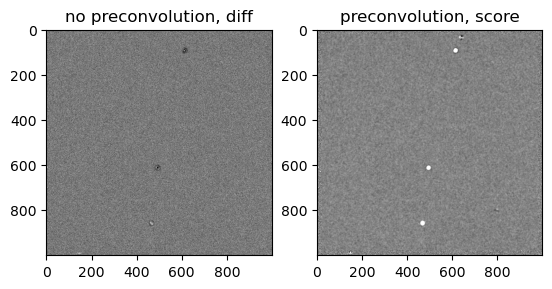

In [124]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(interval(diff_test_default.difference.getImage().array), cmap='gray')
ax[0].set_title('no preconvolution, diff')
ax[1].imshow(interval(diff_test.scoreExposure.getImage().array), cmap='gray')
ax[1].set_title('preconvolution, score')

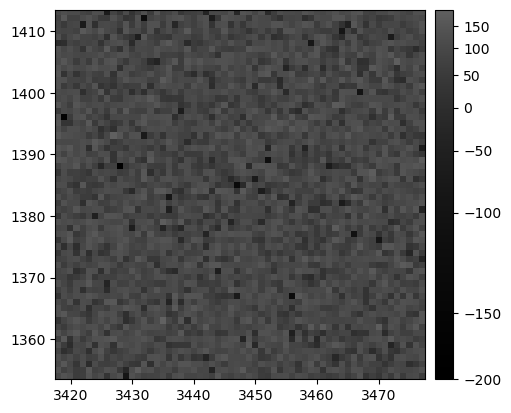

In [125]:
cutout = make_cutout(diff_test_default.difference, x, y, cutout_size=60)
display_exposure_with_mask(cutout, frame=None)

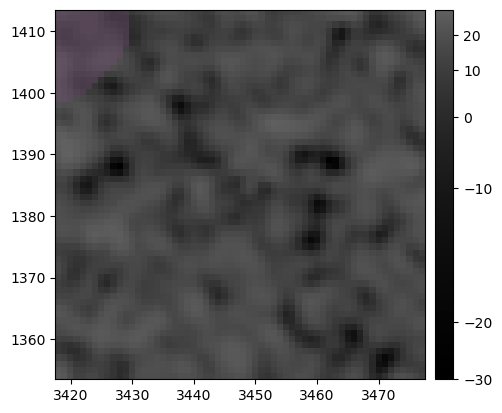

In [126]:
cutout = make_cutout(diff_test.scoreExposure, x, y, cutout_size=60)
display_exposure_with_mask(cutout, frame=None)

In [127]:
det_default = detect(science_cropped, subtraction=diff_test_default)
det_preconv = detect_score(science_cropped, subtraction=diff_test)

/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-7.0.1/Linux64/meas_extensions_trailedSources/g3ddfee87b4+7d0c1c07af/python/lsst/meas/extensions/trailedSources/NaivePlugin.py:393: RuntimeWarning: invalid value encountered in sqrt
  denom = np.sqrt(Ixx - 2.0*Iyy)


In [65]:
# https://github.com/lsst/ip_diffim/blob/aca53a8f8ab4d944834cf730af8db7dc982363cf/tests/test_detectAndMeasure.py#L390

# https://github.com/lsst/ip_diffim/blob/aca53a8f8ab4d944834cf730af8db7dc982363cf/python/lsst/ip/diffim/detectAndMeasure.py#L494

In [60]:
det_test = detect_score(science_cropped, diff_test)

/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-7.0.1/Linux64/meas_extensions_trailedSources/g3ddfee87b4+7d0c1c07af/python/lsst/meas/extensions/trailedSources/NaivePlugin.py:393: RuntimeWarning: invalid value encountered in sqrt
  denom = np.sqrt(Ixx - 2.0*Iyy)


In [64]:
len(det_test.diaSources)

20

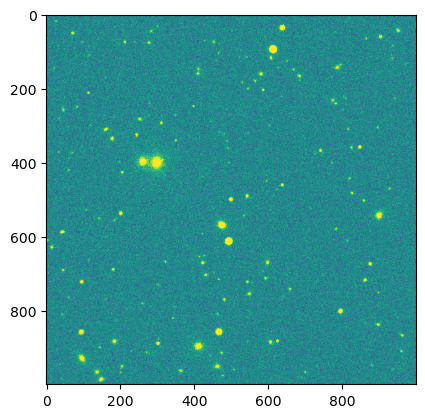

In [63]:
plt.imshow(interval(det_test.subtractedMeasuredExposure.getImage().array))

# saturation artifact

#### mask plane is not updated

In [93]:
sat = keep_flag_astropy(diaSrc, flag_list=SAT_FLAGS)
len(sat)

51

spatial order  1
convolution mode  convolveTemplate
181 stars are used for fitting: 
spatial order  1
181 stars are used for fitting: 


array sum summary
diff.sum() -401009.66 3093625.2


count summary
original: 8, method1: 3, method2 21


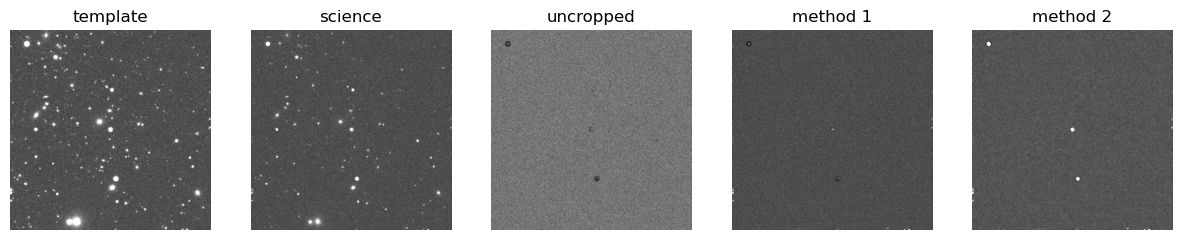

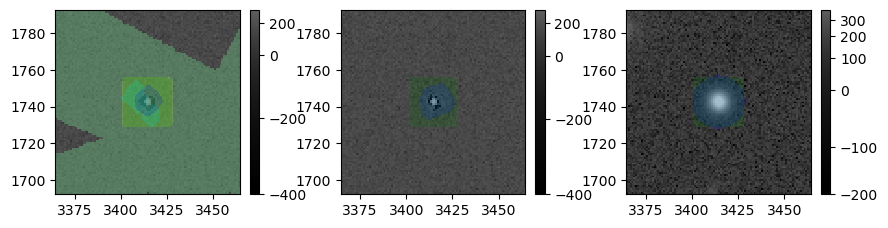

In [104]:
uncropped_vs_cropped(18, diaSrc, sat, science, template, difference, source_catalog, crop_size=1000, offset=10)

spatial order  1
convolution mode  convolveTemplate
106 stars are used for fitting: 
spatial order  1
106 stars are used for fitting: 


array sum summary
diff.sum() nan -4687939.5


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-7.0.1/Linux64/meas_extensions_trailedSources/g3ddfee87b4+7d0c1c07af/python/lsst/meas/extensions/trailedSources/NaivePlugin.py:393: RuntimeWarning: invalid value encountered in sqrt
  denom = np.sqrt(Ixx - 2.0*Iyy)




count summary
original: 0, method1: 3, method2 1


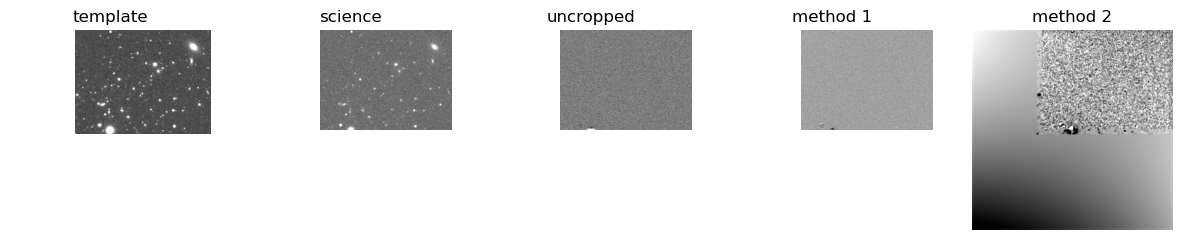

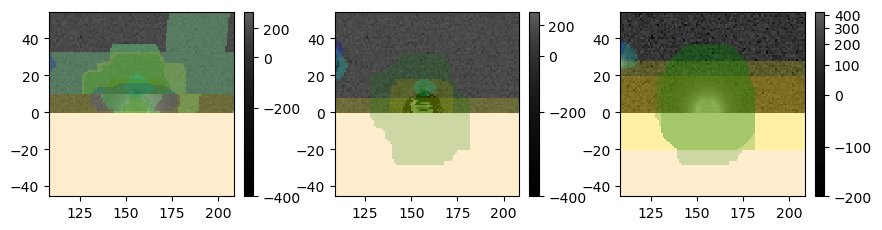

In [111]:
uncropped_vs_cropped(0, diaSrc, sat, science, template, difference, source_catalog, crop_size=1000, offset=10)

spatial order  1
convolution mode  convolveTemplate
89 stars are used for fitting: 
spatial order  1
89 stars are used for fitting: 


array sum summary
diff.sum() nan -31032248.0


count summary
original: 5, method1: 2, method2 26


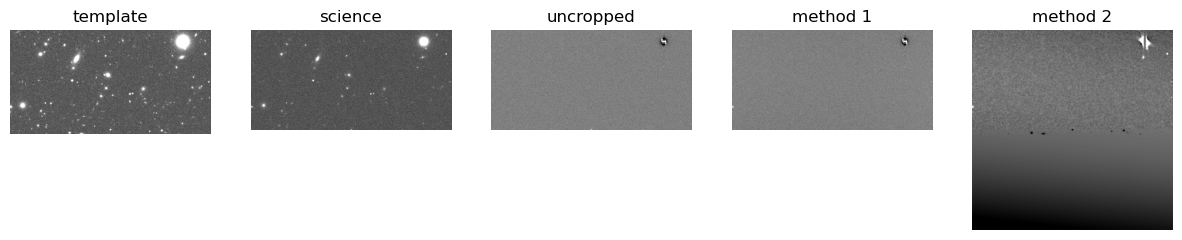

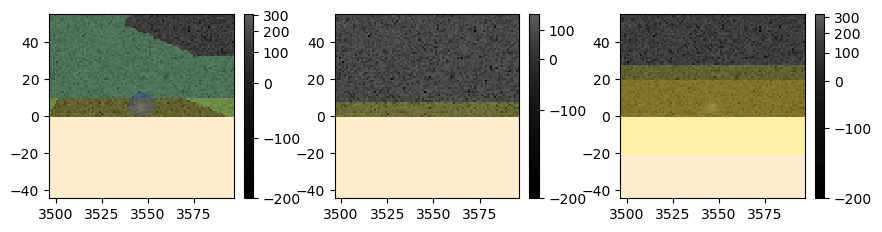

In [112]:
uncropped_vs_cropped(1, diaSrc, sat, science, template, difference, source_catalog, crop_size=1000, offset=10)

In [30]:
# uncropped_vs_cropped(4, diaSrc, sat, science, template, difference, source_catalog, crop_size=1000, offset=10)
# kernel restart for this object

# non-saturation artifact

In [113]:
artifacts = remove_flag_astropy(diaSrc, flag_list=SAT_FLAGS)

spatial order  1
convolution mode  convolveTemplate
122 stars are used for fitting: 
spatial order  1
122 stars are used for fitting: 


array sum summary
diff.sum() 493665.9 297761.44


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-7.0.1/Linux64/meas_extensions_trailedSources/g3ddfee87b4+7d0c1c07af/python/lsst/meas/extensions/trailedSources/NaivePlugin.py:393: RuntimeWarning: invalid value encountered in sqrt
  denom = np.sqrt(Ixx - 2.0*Iyy)




count summary
original: 2, method1: 1, method2 15


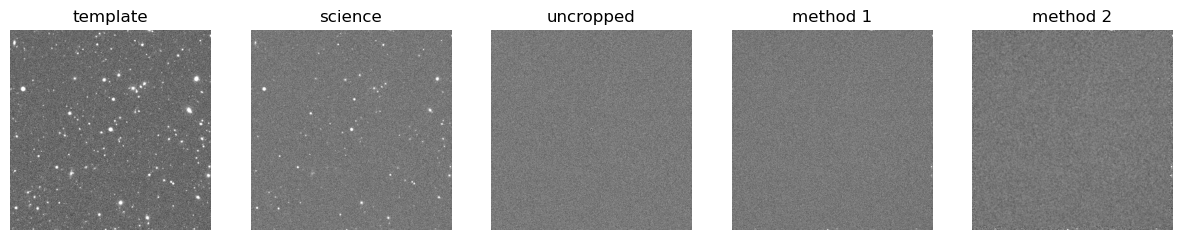

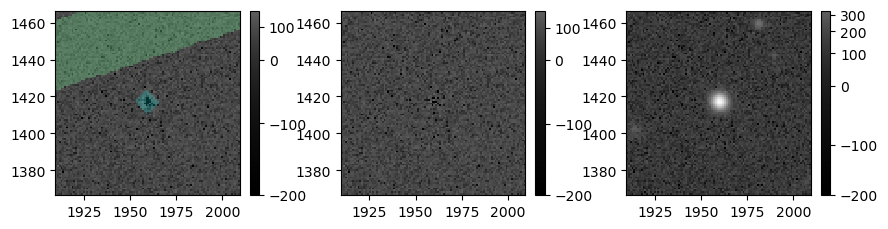

In [114]:
uncropped_vs_cropped(15, diaSrc, artifacts, science, template, difference, source_catalog, crop_size=1000, offset=10)

spatial order  1
convolution mode  convolveTemplate
157 stars are used for fitting: 
spatial order  1
157 stars are used for fitting: 


array sum summary
diff.sum() nan 551062.56


count summary
original: 1, method1: 2, method2 10


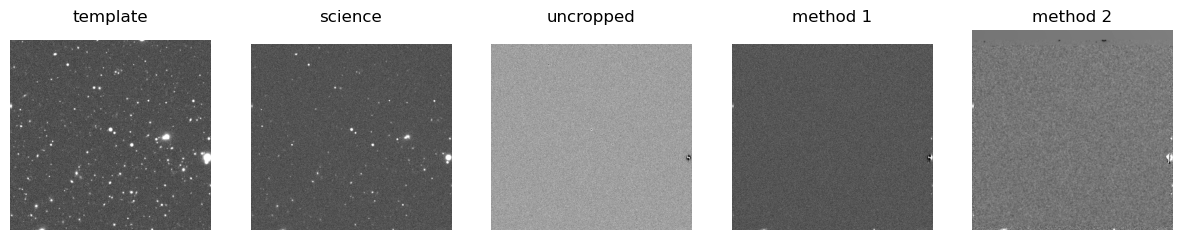

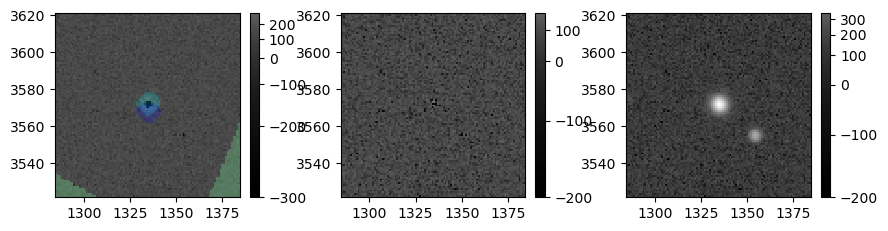

In [115]:
uncropped_vs_cropped(29, diaSrc, artifacts, science, template, difference, source_catalog, crop_size=1000, offset=10)

spatial order  1
convolution mode  convolveTemplate
98 stars are used for fitting: 
spatial order  1
98 stars are used for fitting: 


array sum summary
diff.sum() nan -9874012.0


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-7.0.1/Linux64/meas_extensions_trailedSources/g3ddfee87b4+7d0c1c07af/python/lsst/meas/extensions/trailedSources/NaivePlugin.py:393: RuntimeWarning: invalid value encountered in sqrt
  denom = np.sqrt(Ixx - 2.0*Iyy)




count summary
original: 1, method1: 2, method2 8


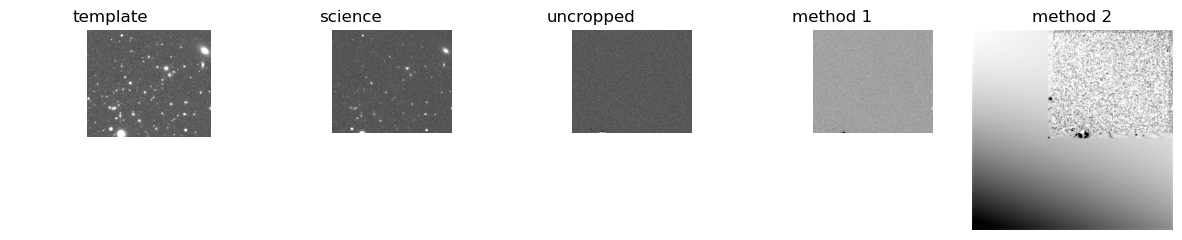

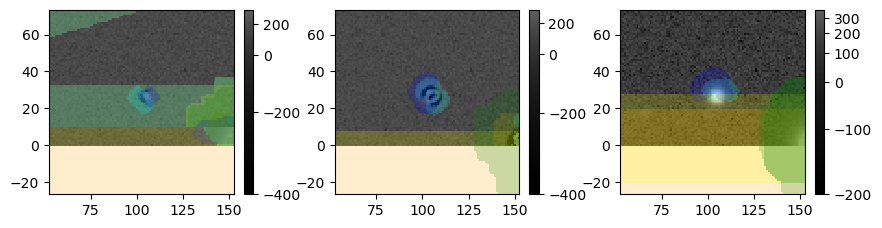

In [116]:
uncropped_vs_cropped(0 , diaSrc, artifacts, science, template, difference, source_catalog, crop_size=1000, offset=10)

spatial order  1
convolution mode  convolveTemplate
201 stars are used for fitting: 
spatial order  1
201 stars are used for fitting: 


array sum summary
diff.sum() -474775.25 1691887.5


count summary
original: 8, method1: 4, method2 20


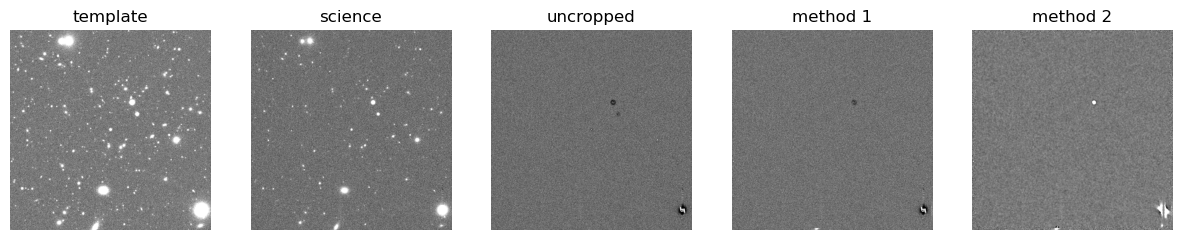

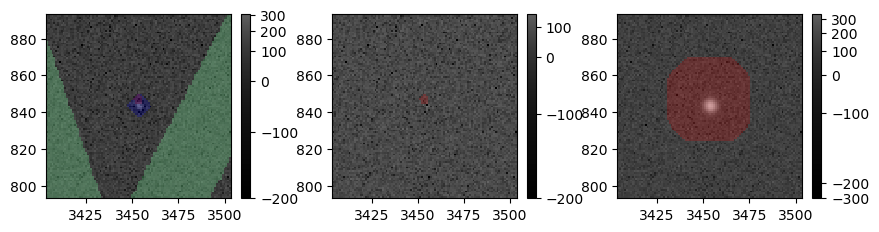

In [117]:
uncropped_vs_cropped(8, diaSrc, artifacts, science, template, difference, source_catalog, crop_size=1000, offset=10)

spatial order  1
convolution mode  convolveTemplate
87 stars are used for fitting: 
spatial order  1
87 stars are used for fitting: 


array sum summary
diff.sum() nan -2491978.0


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-7.0.1/Linux64/meas_extensions_trailedSources/g3ddfee87b4+7d0c1c07af/python/lsst/meas/extensions/trailedSources/NaivePlugin.py:393: RuntimeWarning: invalid value encountered in sqrt
  denom = np.sqrt(Ixx - 2.0*Iyy)




count summary
original: 6, method1: 1, method2 4


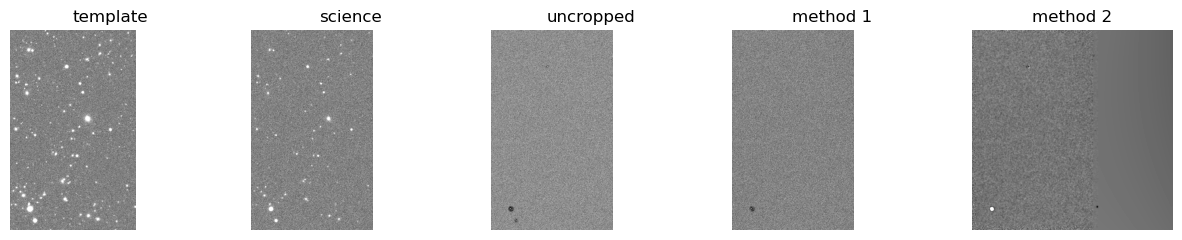

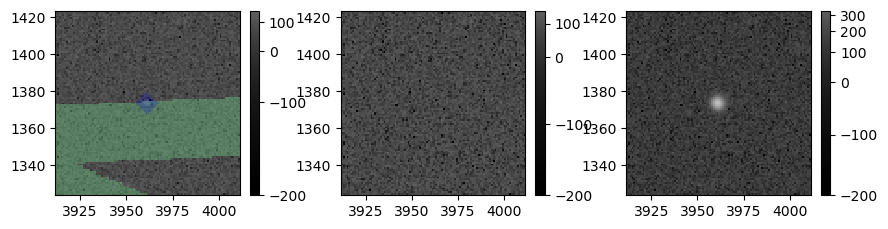

In [118]:
uncropped_vs_cropped(13, diaSrc, artifacts, science, template, difference, source_catalog, crop_size=1000, offset=10)

spatial order  1
convolution mode  convolveTemplate
193 stars are used for fitting: 
spatial order  1
193 stars are used for fitting: 


array sum summary
diff.sum() -1216536.5 2591104.8


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-7.0.1/Linux64/meas_extensions_trailedSources/g3ddfee87b4+7d0c1c07af/python/lsst/meas/extensions/trailedSources/NaivePlugin.py:393: RuntimeWarning: invalid value encountered in sqrt
  denom = np.sqrt(Ixx - 2.0*Iyy)




count summary
original: 9, method1: 3, method2 20


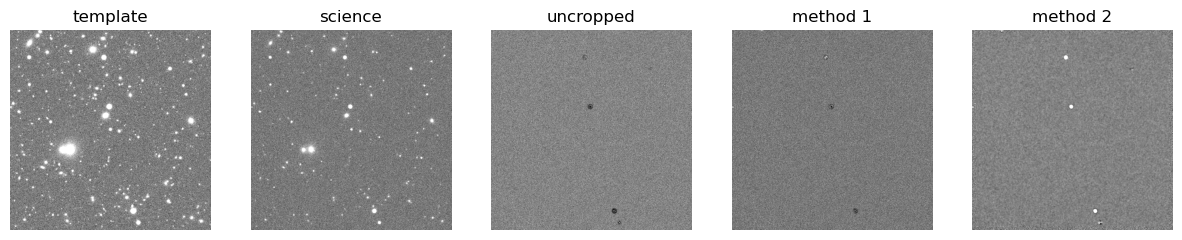

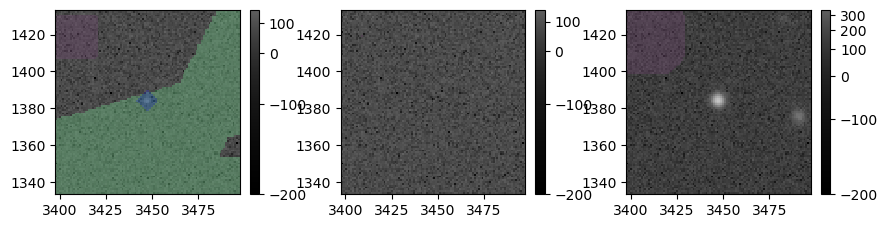

In [119]:
uncropped_vs_cropped(14, diaSrc, artifacts, science, template, difference, source_catalog, crop_size=1000, offset=10)

# fluctuations

In [120]:
fluc = remove_flag_astropy(diaSrc, flag_list=SAT_FLAGS+DIPOLE_FLAGS+SHAPE_FLAGS)
len(fluc)

13

spatial order  1
convolution mode  convolveTemplate
137 stars are used for fitting: 
spatial order  1
137 stars are used for fitting: 


array sum summary
diff.sum() -117425.34 1143702.2


count summary
original: 2, method1: 2, method2 27


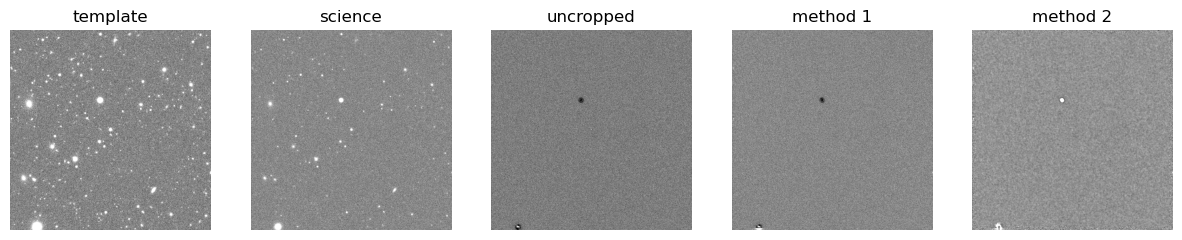

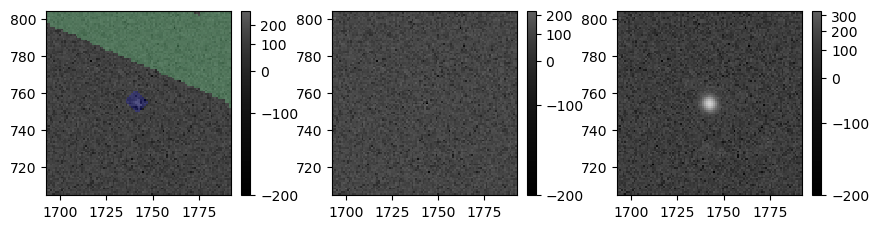

In [121]:
uncropped_vs_cropped(3, diaSrc, fluc, science, template, difference, source_catalog, crop_size=1000, offset=10)

spatial order  1
convolution mode  convolveTemplate
141 stars are used for fitting: 
spatial order  1
141 stars are used for fitting: 


array sum summary
diff.sum() nan 2958386.5


count summary
original: 11, method1: 5, method2 19


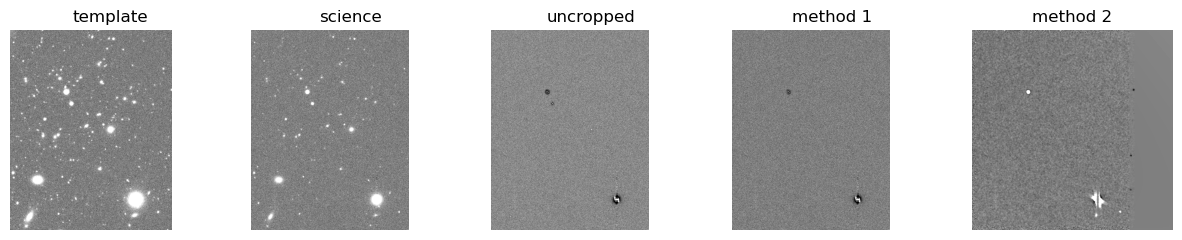

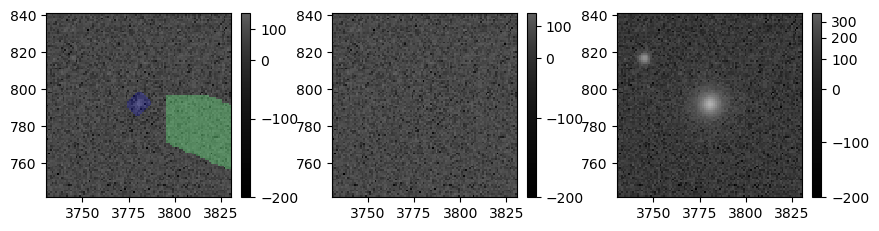

In [122]:
uncropped_vs_cropped(4, diaSrc, fluc, science, template, difference, source_catalog, crop_size=1000, offset=10)

pre-convolution, 